In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torchvision

from model import Discriminator, Generator, InpaintModel
from preprocess import get_images, get_mask
from torchsummary import summary
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
n_epochs = 10
alpha = 0.02
learning_rate = 0.01
batch_size = 32

In [5]:
train_loader, test_loader = get_images(batch_size)
image_size = (32, 32)
square_size = 16
binary_mask = get_mask(image_size, square_size)
# reshape binary mask to add batch_size dimension
binary_mask = binary_mask.unsqueeze(0)
binary_mask = binary_mask.expand(batch_size, -1, -1)
binary_mask = binary_mask.to(device)

print(binary_mask.shape)

Files already downloaded and verified
torch.Size([32, 32, 32])


In [6]:
generator = Generator().to(device)
summary(generator, [(3, 32, 32), (32, 32)])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 32, 32]           --
|    └─GatedConv: 2-1                    [-1, 32, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 32, 32, 32]          3,232
|    |    └─Conv2d: 3-2                  [-1, 32, 32, 32]          3,232
|    |    └─Sigmoid: 3-3                 [-1, 32, 32, 32]          --
|    |    └─LeakyReLU: 3-4               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-5               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-6               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-7               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 32, 32]           --
|    └─GatedConv: 2-1                    [-1, 32, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 32, 32, 32]          3,232
|    |    └─Conv2d: 3-2                  [-1, 32, 32, 32]          3,232
|    |    └─Sigmoid: 3-3                 [-1, 32, 32, 32]          --
|    |    └─LeakyReLU: 3-4               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-5               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-6               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-7               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |   

In [7]:
discriminator = Discriminator().to(device)
summary(discriminator, [(3, 32, 32), (32, 32)])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─SpectralNormConv: 2-1             [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 16, 16]          6,464
|    |    └─LeakyReLU: 3-2               [-1, 64, 16, 16]          --
|    └─SpectralNormConv: 2-2             [-1, 128, 8, 8]           --
|    |    └─Conv2d: 3-3                  [-1, 128, 8, 8]           204,928
|    |    └─LeakyReLU: 3-4               [-1, 128, 8, 8]           --
|    └─SpectralNormConv: 2-3             [-1, 256, 4, 4]           --
|    |    └─Conv2d: 3-5                  [-1, 256, 4, 4]           819,456
|    |    └─LeakyReLU: 3-6               [-1, 256, 4, 4]           --
|    └─SpectralNormConv: 2-4             [-1, 256, 2, 2]           --
|    |    └─Conv2d: 3-7                  [-1, 256, 2, 2]           1,638,656
|    |    └─LeakyReLU: 3-8               [-1, 256, 2, 2]         

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─SpectralNormConv: 2-1             [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 16, 16]          6,464
|    |    └─LeakyReLU: 3-2               [-1, 64, 16, 16]          --
|    └─SpectralNormConv: 2-2             [-1, 128, 8, 8]           --
|    |    └─Conv2d: 3-3                  [-1, 128, 8, 8]           204,928
|    |    └─LeakyReLU: 3-4               [-1, 128, 8, 8]           --
|    └─SpectralNormConv: 2-3             [-1, 256, 4, 4]           --
|    |    └─Conv2d: 3-5                  [-1, 256, 4, 4]           819,456
|    |    └─LeakyReLU: 3-6               [-1, 256, 4, 4]           --
|    └─SpectralNormConv: 2-4             [-1, 256, 2, 2]           --
|    |    └─Conv2d: 3-7                  [-1, 256, 2, 2]           1,638,656
|    |    └─LeakyReLU: 3-8               [-1, 256, 2, 2]         

In [8]:
model = InpaintModel().to(device)
summary(model, [(3, 32, 32), (32, 32)])

Layer (type:depth-idx)                   Output Shape              Param #
├─Generator: 1-1                         [-1, 3, 32, 32]           --
|    └─Sequential: 2-1                   [-1, 3, 32, 32]           --
|    |    └─GatedConv: 3-1               [-1, 32, 32, 32]          6,528
|    |    └─GatedConv: 3-2               [-1, 64, 16, 16]          37,120
|    |    └─GatedConv: 3-3               [-1, 64, 16, 16]          73,984
|    |    └─GatedConv: 3-4               [-1, 128, 8, 8]           147,968
|    |    └─GatedConv: 3-5               [-1, 128, 8, 8]           295,424
|    |    └─GatedConv: 3-6               [-1, 128, 8, 8]           295,424
|    |    └─GatedConv: 3-7               [-1, 128, 8, 8]           295,424
|    |    └─GatedConv: 3-8               [-1, 128, 8, 8]           295,424
|    |    └─GatedConv: 3-9               [-1, 128, 8, 8]           295,424
|    |    └─GatedConv: 3-10              [-1, 128, 8, 8]           295,424
|    |    └─GatedConv: 3-11            

Layer (type:depth-idx)                   Output Shape              Param #
├─Generator: 1-1                         [-1, 3, 32, 32]           --
|    └─Sequential: 2-1                   [-1, 3, 32, 32]           --
|    |    └─GatedConv: 3-1               [-1, 32, 32, 32]          6,528
|    |    └─GatedConv: 3-2               [-1, 64, 16, 16]          37,120
|    |    └─GatedConv: 3-3               [-1, 64, 16, 16]          73,984
|    |    └─GatedConv: 3-4               [-1, 128, 8, 8]           147,968
|    |    └─GatedConv: 3-5               [-1, 128, 8, 8]           295,424
|    |    └─GatedConv: 3-6               [-1, 128, 8, 8]           295,424
|    |    └─GatedConv: 3-7               [-1, 128, 8, 8]           295,424
|    |    └─GatedConv: 3-8               [-1, 128, 8, 8]           295,424
|    |    └─GatedConv: 3-9               [-1, 128, 8, 8]           295,424
|    |    └─GatedConv: 3-10              [-1, 128, 8, 8]           295,424
|    |    └─GatedConv: 3-11            

In [9]:
learning_rate_gen = 0.01
learning_rate_dis = 0.03

opt_generator = torch.optim.Adam(model.generator.parameters(), lr=0.0001)
opt_discriminator = torch.optim.Adam(model.discriminator.parameters(), lr=0.0004)

In [10]:
discriminator_freq = 5
generator_freq = 1

In [11]:
for epoch in range(n_epochs):
    #Training
    train_loss = 0
    loss = 0
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        if data.shape[0] != batch_size:
            continue
        data = data.to(device)
        binary_mask = binary_mask.to(device)

        ### TRAIN THE DISCRIMINATOR ###
        if batch_idx % discriminator_freq == 0:
            # model forward
            x_fake, x_coarse, x_refinement = model(data, binary_mask)
            x_all = torch.cat([x_fake, data], dim=0)
            masks_double = torch.cat([binary_mask, binary_mask], dim=0)
            # clear the gradients of all optimized variables for discriminator
            opt_discriminator.zero_grad()
            x_hat_all = model.discriminator(x_all, masks_double)
            fake_output = x_hat_all[:batch_size]
            real_output = x_hat_all[batch_size:]
            
            # compute the discriminator loss
            loss_dis = model.discriminator.loss_function(real_output, fake_output)
            # backward/update discriminator
            loss_dis.backward()
            opt_discriminator.step()

            train_loss += loss_dis
        
        ### TRAIN THE GENERATOR ###
        if batch_idx % generator_freq == 0:
            # model forward
            x_fake, x_coarse, x_refinement = model(data, binary_mask)
            x_hat_dis = model.discriminator(x_fake, binary_mask)
            # clear the gradients of all optimized variables for generator
            opt_generator.zero_grad()
            # compute the generator loss
            loss_gen = model.generator.loss_function(x_hat_dis)
            loss_recon = model.generator.combined_rec_loss_function(data, x_coarse, x_refinement, binary_mask, 1/40)
            if np.random.uniform(0, 1) >= 0.1:
                loss_gen += loss_recon
            # backward/update generator
            loss_gen.backward()
            opt_generator.step()

            train_loss += loss_gen

    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


Epoch: 0 	Training Loss: 0.427231
Epoch: 1 	Training Loss: 0.381267
Epoch: 2 	Training Loss: 0.389668
Epoch: 3 	Training Loss: 0.385604
Epoch: 4 	Training Loss: 0.385535
Epoch: 5 	Training Loss: 0.385412
Epoch: 6 	Training Loss: 0.386604
Epoch: 7 	Training Loss: 0.385577
Epoch: 8 	Training Loss: 0.383835
Epoch: 9 	Training Loss: 0.382592


In [12]:
#Testing

test_loss = count = 0
loss = 0
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(test_loader):
        if data.shape[0] != batch_size:
            continue
        images = data.to(device)
        masks = binary_mask.to(device)
        # model forward
        fake_images, _, _ = model(images, masks)
        all_images = torch.cat([fake_images, images], dim=0)
        double_masks = torch.cat([masks, masks], dim=0)

        all_output = model.discriminator(all_images, double_masks)
        fake_output = all_output[:images.size(0)]
        real_output = all_output[images.size(0):]
        
        # compute the loss
        loss_dis = discriminator.loss_function(real_output, fake_output)
        loss_gen = generator.loss_function(fake_output)
        # update running training loss
        test_loss += (loss_gen + loss_dis)
        
        input = images
        output = fake_images

    test_loss = test_loss / len(test_loader)
    print('Test Loss: {:.6f}'.format(test_loss))

Test Loss: 1.972376


In [13]:
# val_loss = count = 0
# torch.cuda.empty_cache()
# inpaint.eval()
# input = None
# output = None

# with torch.no_grad():
#     for batch_idx, (data, _) in enumerate(test_loader):
#         if data.shape[0] != batch_size:
#             continue
#         data = data.to(device)
#         binary_mask = binary_mask.to(device)
#         x_hat = inpaint(data, binary_mask)
#         loss = inpaint.loss_function(x_hat, data, binary_mask, alpha)
#         val_loss += loss
#         count += 1

#         input = data
#         output = x_hat
    
# val_loss = val_loss / count
# print(f'Validation loss: {val_loss:.4f}')


In [14]:
# B x C x H x W
input = input[:5]
output = output[:5]

# B x H x W x C
input = input.permute(0, 2, 3, 1)
output = output.permute(0, 2, 3, 1)

input = input.cpu()
output = output.cpu()

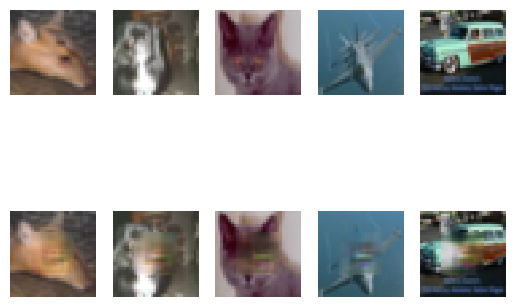

In [15]:
f, axarr = plt.subplots(2,5)
axarr[0, 0].axis("off")
axarr[0, 0].imshow(input[0], interpolation='nearest')
axarr[0, 1].axis("off")
axarr[0, 1].imshow(input[1], interpolation='nearest')
axarr[0, 2].axis("off")
axarr[0, 2].imshow(input[2], interpolation='nearest')
axarr[0, 3].axis("off")
axarr[0, 3].imshow(input[3], interpolation='nearest')
axarr[0, 4].axis("off")
axarr[0, 4].imshow(input[4], interpolation='nearest')

axarr[1, 0].axis("off")
axarr[1, 0].imshow(output[0], interpolation='nearest')
axarr[1, 1].axis("off")
axarr[1, 1].imshow(output[1], interpolation='nearest')
axarr[1, 2].axis("off")
axarr[1, 2].imshow(output[2], interpolation='nearest')
axarr[1, 3].axis("off")
axarr[1, 3].imshow(output[3], interpolation='nearest')
axarr[1, 4].axis("off")
axarr[1, 4].imshow(output[4], interpolation='nearest')